In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import files
uploaded = files.upload()


Saving parkinsons.csv to parkinsons.csv


In [8]:
df = pd.read_csv('parkinsons.csv')

In [9]:
df.shape

(195, 24)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [11]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Data Cleaning

In [20]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df[filtered_columns]
df.shape

ValueError: could not convert string to float: 'phon_R01_S01_1'

In [22]:
print(df.columns)


Index(['name', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')


In [23]:
df = df.groupby('name').mean().reset_index()
df.drop('name', axis=1, inplace=True)

In [24]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df[filtered_columns]
df.shape

(195, 10)

In [26]:
print(df.columns)


Index(['D2', 'spread2', 'spread1', 'DFA', 'RPDE', 'status', 'HNR',
       'MDVP:Jitter(%)', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)'],
      dtype='object')


In [39]:
X = df.drop('spread2', axis=1)
X_norm = MinMaxScaler().fit_transform(X)

# Use a score function suitable for continuous data
from sklearn.feature_selection import f_regression
selector = SelectKBest(f_regression, k=min(30, X.shape[1]))

selector.fit(X_norm, df['spread2'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['spread2'] = df['spread2']
df = filtered_data
df.shape

(195, 10)

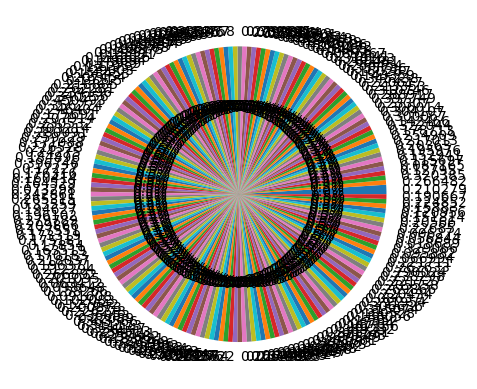

In [40]:
x = df['spread2'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

Model Training

In [41]:
features = df.drop('spread2', axis=1)
target = df['spread2']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)
X_train.shape, X_val.shape

((156, 9), (39, 9))

In [43]:
# Assuming 'spread2' needs to be treated as a classification problem,
# you might need to discretize it. Here's one way using pandas.cut:

# Discretize 'spread2' into bins
num_bins = 3  # Adjust this based on your problem
df['spread2_binned'] = pd.cut(df['spread2'], bins=num_bins, labels=False)

# Now use the binned version as your target
features = df.drop(['spread2', 'spread2_binned'], axis=1)
target = df['spread2_binned']

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size=0.2,
                                                  random_state=10)

# Now you can use RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape

((230, 9), (230,))

In [48]:
from sklearn.metrics import roc_auc_score as ras
models = [LogisticRegression(), XGBClassifier(), SVC(probability=True)]

for i in range(len(models)):
    models[i].fit(X, Y)

    print(f'{models[i]} : ')

    train_preds = models[i].predict_proba(X)
    print('Training Accuracy : ', ras(Y, train_preds, multi_class='ovo'))

    val_preds = models[i].predict_proba(X_val)
    print('Validation Accuracy : ', ras(Y_val, val_preds, multi_class='ovo'))
    print()

LogisticRegression() : 
Training Accuracy :  0.8259303476316514
Validation Accuracy :  0.7027089072543617

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.8460743801652892

SVC(probability=True) : 
Training Accuracy :  0.6863554

Model Evaluation

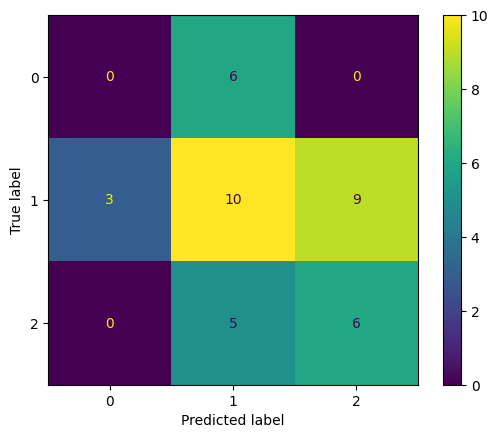

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(models[0], X_val, Y_val)
plt.show()

In [51]:
print(metrics.classification_report(Y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.48      0.45      0.47        22
           2       0.40      0.55      0.46        11

    accuracy                           0.41        39
   macro avg       0.29      0.33      0.31        39
weighted avg       0.38      0.41      0.39        39

